This is our project notebook. Firstly, we'll import some packages, along with the pystan_utils used in class.

In [154]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [305]:
pop_I = 60470842
pop_S = 46752937
pd_I = 206
pd_S = 94
urb_I = 69.5
urb_S = 80.3

This data was obtained from https://www.worldometers.info/ and is the population, population density, and urban population percentage of each country.

Now to read in the COVID19 deaths dataset alongside some other useful information about the countries. It took a lot of playing around with the dataset but it now only contains countries, whereas before some countries were split into regions. I then take the two countries that we will focus on: Italy and Spain.

In [3]:
df1 = pd.read_csv("time_series_covid19_deaths_global.csv.txt")
df2 = df1.drop(df1.columns[[0,2,3]], axis=1)
df3 = df2.iloc[0:265,31:112][0:265].astype(int)
df4 = pd.merge(df2.loc[:,'Country/Region'][0:265],df3,left_index=True,right_index=True)
df5 = df4.groupby(['Country/Region']).sum()
df6 = df5.loc[['Italy','Spain']]
print(df6)

                2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  \
Country/Region                                                                  
Italy                 1        2        3        7       10       12       17   
Spain                 0        0        0        0        0        0        0   

                2/28/20  2/29/20  3/1/20  ...  5/2/20  5/3/20  5/4/20  5/5/20  \
Country/Region                            ...                                   
Italy                21       29      34  ...   28710   28884   29079   29315   
Spain                 0        0       0  ...   25100   25264   25428   25613   

                5/6/20  5/7/20  5/8/20  5/9/20  5/10/20  5/11/20  
Country/Region                                                    
Italy            29684   29958   30201   30395    30560    30739  
Spain            25857   26070   26299   26478    26621    26744  

[2 rows x 81 columns]


In [183]:
y = df6.values
Italy = y[0,:][np.nonzero(y[0,:])]
Spain = y[1,:][np.nonzero(y[1,:])]

Here I have removed all zeros from the two time series

Text(0, 0.5, 'Total deaths')

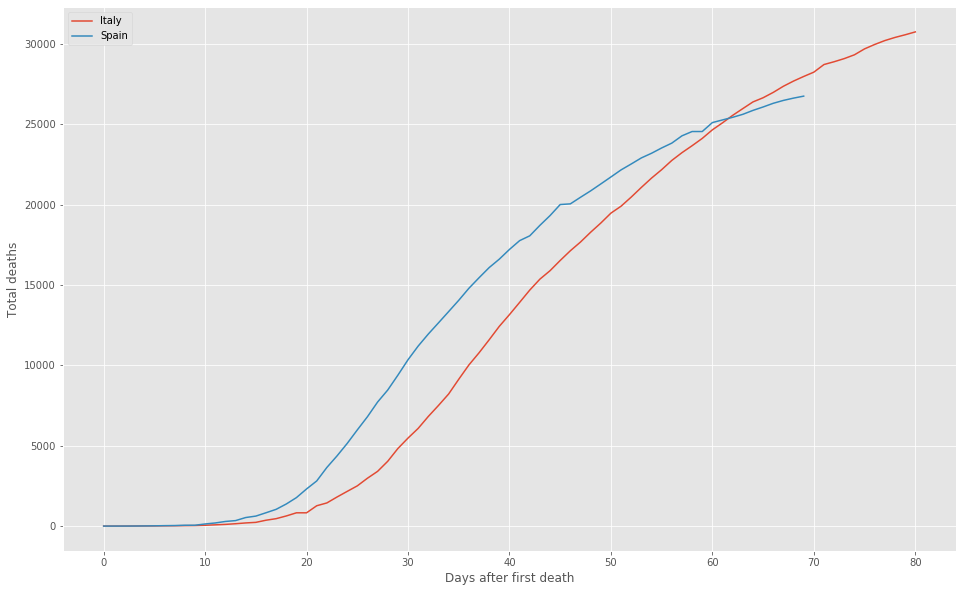

In [184]:
plt.plot(range(81),Italy,range(70),Spain)
plt.legend(df6.index.values)
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

As you can see, Spain and Italy have similar S-shaped death curves. Italy has more data as it's first death was recorded earlier in the year.

The code below splits Spain and Italy into training and testing sets. 

In [7]:
train_perc = 0.66 # percentage of training data
split_point_S = int(train_perc*len(Spain))
Spain_train = Spain[:split_point_S]
Spain_test = Spain[split_point_S:]
split_point_I = int(train_perc*len(Italy))
Italy_train = Italy[:split_point_I]
Italy_test = Italy[split_point_I:]
print("num train Spain: %d" % len(Spain_train))
print("num test Spain: %d" % len(Spain_test))
print("num train Italy: %d" % len(Italy_train))
print("num test Italy: %d" % len(Italy_test))

num train Spain: 46
num test Spain: 24
num train Italy: 53
num test Italy: 28


Below is a basic first model. It works by simply predicting the next day's death total to be the same as the current days' total. This is a poor model as it only predicts one day ahead and so we will not be using anything similar to this. We are only using this to highlight what a succesful model would look like statistically as we expect it to have low RMSE and high R2. We do not consider this model to be succesful though because it can't predict further than one day ahead.

In [185]:
model_base = """
data {
    int<lower=1> T_r;
    int<lower=0> T_t;
    real y[T_r+T_t];
}

generated quantities {
    real y_hat[T_t];
    for(t in 1:(T_t)){
        y_hat[t] = y[T_r+t-1];
    }
}
"""

In [186]:
T_r = len(Italy_train)
T_t = len(Italy_test)
data = {'T_r': T_r, 'T_t': T_t, 'y': Italy}

In [187]:
%%time
sm = pystan.StanModel(model_code=model_base)
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="Fixed_param", seed=42, verbose=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f1e40363975de54a16bc95cc59279b60 NOW.


Inference for Stan model: anon_model_f1e40363975de54a16bc95cc59279b60.
4 chains, each with iter=500; warmup=0; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y_hat[1]   2.0e4     nan    0.0  2.0e4  2.0e4  2.0e4  2.0e4  2.0e4    nan    nan
y_hat[2]   2.1e4     nan    0.0  2.1e4  2.1e4  2.1e4  2.1e4  2.1e4    nan    nan
y_hat[3]   2.2e4     nan    0.0  2.2e4  2.2e4  2.2e4  2.2e4  2.2e4    nan    nan
y_hat[4]   2.2e4     nan    0.0  2.2e4  2.2e4  2.2e4  2.2e4  2.2e4    nan    nan
y_hat[5]   2.3e4     nan    0.0  2.3e4  2.3e4  2.3e4  2.3e4  2.3e4    nan    nan
y_hat[6]   2.3e4     nan    0.0  2.3e4  2.3e4  2.3e4  2.3e4  2.3e4    nan    nan
y_hat[7]   2.4e4     nan    0.0  2.4e4  2.4e4  2.4e4  2.4e4  2.4e4    nan    nan
y_hat[8]   2.4e4     nan    0.0  2.4e4  2.4e4  2.4e4  2.4e4  2.4e4    nan    nan
y_hat[9]   2.5e4     nan    0.0  2.5e4  2.5e4  2.5e4  2.5e4  2.5e4    nan    nan
y_hat[

In [202]:
samples = fit.extract(permuted=True)
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

Text(0, 0.5, 'Total deaths')

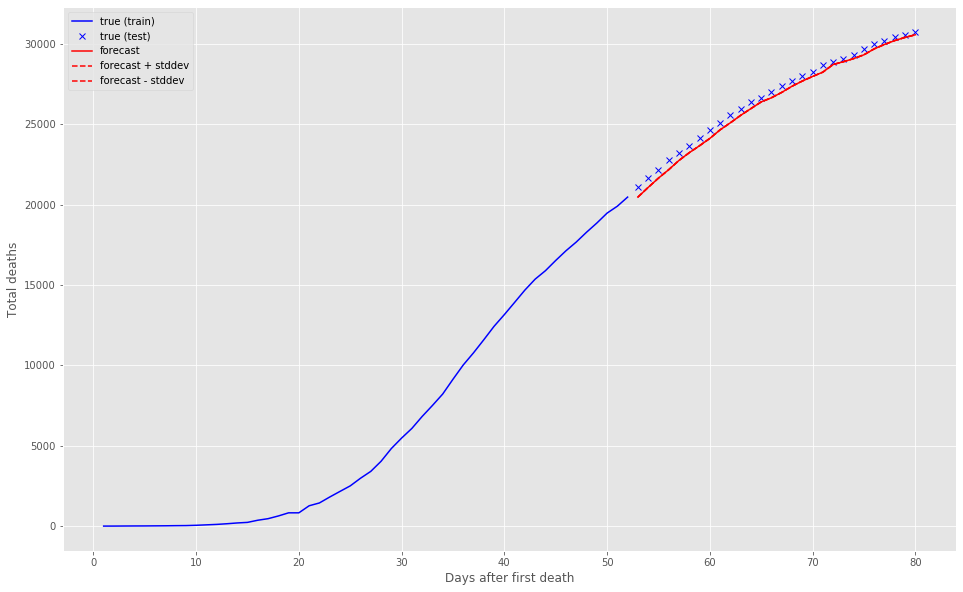

In [203]:
plt.plot(range(1,T_r), Italy[1:T_r], "b-")
plt.plot(range(T_r,T_r+T_t), Italy[T_r:T_r+T_t], "bx")
plt.plot(range(T_r,T_r+T_t), y_hat, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [190]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [191]:
corr, mae, rae, rmse, r2 = compute_error(Italy_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 1.000
MAE: 366.92857
RMSE: 390.37079
R2: 0.982


As expected, this model has very low RMSE and high R2 for the Italy data set. Let's see if we can beat it with a model that predicts more than one day ahead.

In [16]:
model_base2 = """
data {
    int<lower=1> T_t;
    int<lower=1> T_r;
    vector<lower=0>[T_r+T_t] y;
}

parameters {
    real<lower=0> tau;
    real<lower=0,upper=2> beta;
    real<lower=0> sigma;
    real<lower=0> B;
    vector<lower=0>[T_r] z;
}

model {
    beta ~ normal(0,1);
    tau ~ normal(0,1);
    sigma ~ normal(0,1);
    B ~ normal(0,1);
    z[1] ~ normal(0,10);
    for(t in 2:(T_r)){
        z[t] ~ normal(beta*z[t-1],tau);
    }
    y[1:T_r] ~ normal(B*z[1:T_r],sigma);
}

generated quantities {
    real y_hat[T_t];                         // vector to store predictions
    real z_hat[T_t];
    z_hat[1] = normal_rng(beta*z[T_r],tau);
    for (t in 2:T_t){
        z_hat[t] = normal_rng(beta*z_hat[t-1],tau);
    }
    for (t in 1:T_t) {
        y_hat[t] = normal_rng(B*z_hat[t],sigma);  // predictions
    }
}
"""

This second model is also a base model to test against. It forecasts the test set for Italy so is more applicable than the previous model. It uses a latent state to find the value for y, the total deaths in Italy. The data is modelled like:
$$z_t \sim Normal(z_t|\beta \cdot z_{t-1},\tau)$$
$$y_t \sim Normal(y_t|B \cdot z_t, \sigma)$$
Then, the forecasts for the latent states and y are made in the generated quantities section.

In [194]:
data2 = {'T_r': T_r, 'T_t': T_t, 'y': Italy}

In [195]:
%%time
sm2 = pystan.StanModel(model_code=model_base2)
fit2 = sm2.sampling(data=data2, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3547e3179909e4a1ddfc701a538c2b61 NOW.


Inference for Stan model: anon_model_3547e3179909e4a1ddfc701a538c2b61.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau        11.22    0.17    0.7  10.16  10.76  11.03  11.57  12.78     17   1.21
beta        1.05  6.4e-4 2.5e-3   1.04   1.04   1.05   1.05   1.05     16   1.14
sigma      11.85    4.59   7.13   4.71   5.94  10.64  20.24   28.7      2   2.89
B          13.25     0.7   1.25  11.03  12.31   13.1  14.61  15.02      3   2.32
z[1]        1.48    0.68   1.02   0.31   0.59   1.21   2.04   3.29      2   3.44
z[2]        1.25    0.49   0.76   0.33   0.63    1.1   1.83    2.4      2    2.6
z[3]        0.96    0.67    1.0   0.06   0.17   0.61   0.98   2.75      2   3.25
z[4]        0.84    0.32   0.48   0.22   0.28   1.06   1.25   1.71      2   2.84
z[5]        1.41    0.89   1.32   0.14   0.42   0.93   1.68   3.94      2   3.69
z[6]

In [204]:
samples = fit2.extract(permuted=True)
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

Text(0, 0.5, 'Total deaths')

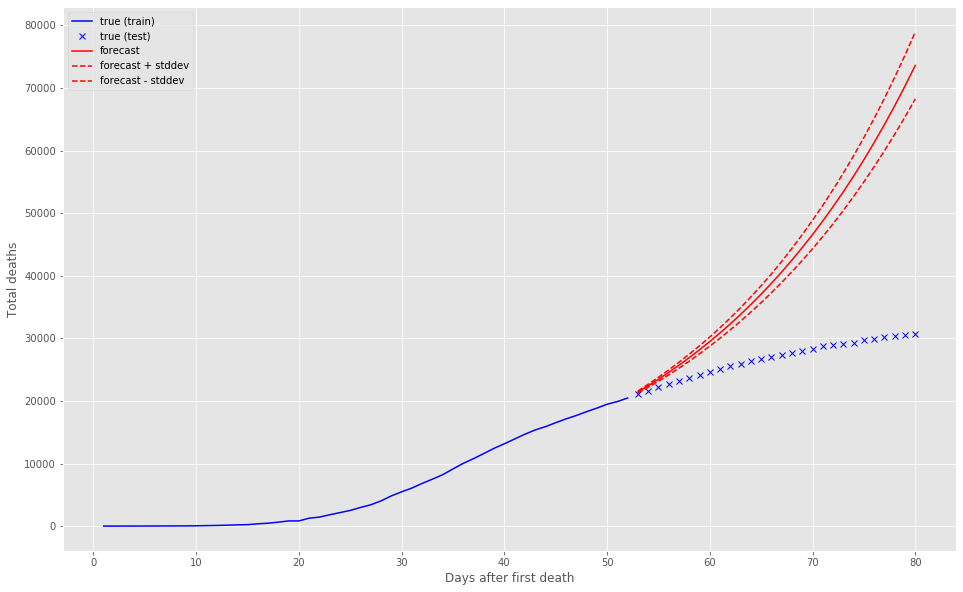

In [205]:
plt.plot(range(1,T_r), Italy[1:T_r], "b-")
plt.plot(range(T_r,T_r+T_t), Italy[T_r:T_r+T_t], "bx")
plt.plot(range(T_r,T_r+T_t), y_hat, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [198]:
corr, mae, rae, rmse, r2 = compute_error(Italy_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.954
MAE: 15721.80993
RMSE: 20239.66041
R2: 0.000


This model is not good at all; it has a very high root mean square error and an r-squared value of 0.000. This base model does, however, forecast more than a day ahead.

The following are the evolutions of our actual model.

In [23]:
Italy_d = np.zeros(len(Italy),dtype=int)
Spain_d = np.zeros(len(Spain),dtype=int)
Italy_d[0] = Italy[0]
Spain_d[0] = Spain[0]
for i in range(1,len(Italy)):
    Italy_d[i] = Italy[i] - Italy[i-1]
for i in range(1,len(Spain)):
    Spain_d[i] = Spain[i] - Spain[i-1]
print(Italy_d)
print(Italy)

[  1   1   1   4   3   2   5   4   8   5  18  27  28  41  49  36 133  97
 168 196   0 439 175 368 349 345 475 427 627 793 651 601 743 683 712 919
 889 756 812 837 727 760 766 681 525 636 604 542 610 570 619 431 566 602
 578 525 575 482 433 454 534 437 464 420 415 260 333 382 323 285 269 474
 174 195 236 369 274 243 194 165 179]
[    1     2     3     7    10    12    17    21    29    34    52    79
   107   148   197   233   366   463   631   827   827  1266  1441  1809
  2158  2503  2978  3405  4032  4825  5476  6077  6820  7503  8215  9134
 10023 10779 11591 12428 13155 13915 14681 15362 15887 16523 17127 17669
 18279 18849 19468 19899 20465 21067 21645 22170 22745 23227 23660 24114
 24648 25085 25549 25969 26384 26644 26977 27359 27682 27967 28236 28710
 28884 29079 29315 29684 29958 30201 30395 30560 30739]


The first thing we do, here, is convert the Italy death data set from cumulative deaths to number of deaths each day. This set is then not strictly increasing.

Text(0, 0.5, 'Daily deaths')

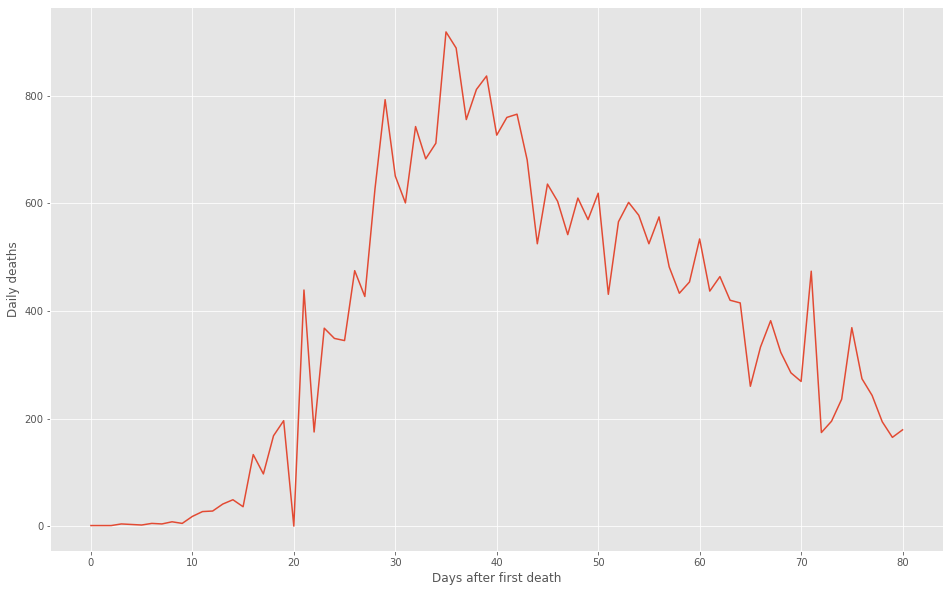

In [206]:
plt.plot(range(len(Italy)),Italy_d)
plt.xlabel("Days after first death")
plt.ylabel("Daily deaths")

In [207]:
model_1 = """
data {
    int<lower=1> T_t;
    int<lower=1> T_r;
    vector<lower=0>[T_r+T_t] y;
}

parameters {
    real<lower=0> tau;
    real<lower=0,upper=2> beta;
    real<lower=0> sigma;
    real<lower=0> B;
    vector<lower=0>[T_r] z;
}

model {
    beta ~ normal(0,1);
    tau ~ normal(0,1);
    sigma ~ normal(0,1);
    B ~ normal(0,1);
    z[1] ~ normal(0,10);
    for(t in 2:(T_r)){
        z[t] ~ normal(beta*z[t-1],tau);
    }
    y[1:T_r] ~ normal(B*z[1:T_r],sigma);
}

generated quantities {
    real y_hat[T_t];                         // vector to store predictions
    real z_hat[T_t];
    z_hat[1] = normal_rng(beta*z[T_r],tau);
    for (t in 2:T_t){
        z_hat[t] = normal_rng(beta*z_hat[t-1],tau);
    }
    for (t in 1:T_t) {
        y_hat[t] = normal_rng(B*z_hat[t],sigma);  // predictions
    }
}
"""

We played around with this first model a lot. Initially, we wanted the y's and y_hat's to be modelled as Poisson distributed due to the daily death counts being integers:
$$z_t \sim Normal(z_t|\beta \cdot z_{t-1},\tau)$$
$$y_t \sim Poisson(y_t|exp(B \cdot z_t))$$
Unfortunately, we could not get this to work due to the exponential function becoming too large. If we removed the exponential then on some samples the rate parameter would be negative and the model would fail. We tried both MCMC and ADVI and it didn't work. Next we tried to pre-calculate the rate parameter in the transformed parameters section, to put bounds on it's size, however this also failed. In the end, we settled on modelling the y's and y_hat's as normally distributed. We put a fat prior on the initial latent state (at time t=1) and then used the following distributions:
$$z_t \sim Normal(z_t|\beta \cdot z_{t-1},\tau)$$
$$y_t \sim Normal(y_t|B \cdot z_t, \sigma)$$
It should be noted that as the latent states are normally distributed, the conjugate priors for them are also normally distributed.

In [208]:
data3 = {'T_r': T_r, 'T_t': T_t, 'y': Italy_d}

In [209]:
%%time
sm3 = pystan.StanModel(model_code=model_1)
fit3 = sm3.sampling(data=data3, iter=500, algorithm="NUTS", seed=42, verbose=True)
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3547e3179909e4a1ddfc701a538c2b61 NOW.


Inference for Stan model: anon_model_3547e3179909e4a1ddfc701a538c2b61.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau         8.85    0.11   0.57   7.69   8.44   8.85   9.35   9.78     27   1.15
beta        0.98  2.6e-3   0.02   0.95   0.96   0.98    1.0   1.02     64   1.04
sigma       0.79    0.08   0.39   0.34   0.55   0.66   0.93   1.81     23   1.18
B           8.37    0.15   0.62   7.32   7.86   8.29   8.83    9.5     17   1.31
z[1]        0.15  9.3e-3   0.09   0.01   0.09   0.14    0.2   0.39     97   1.05
z[2]        0.15  9.4e-3   0.09   0.03    0.1   0.13   0.19   0.36     91   1.04
z[3]        0.15    0.01    0.1   0.02   0.08   0.14   0.22   0.37     75   1.04
z[4]        0.48    0.01   0.12   0.21   0.42   0.49   0.57    0.7     99   1.05
z[5]        0.38    0.01   0.11   0.16   0.31   0.37   0.46    0.6     53   1.06
z[6]

Before plotting the results, we must first convert them back to cumulative death numbers

Text(0, 0.5, 'Total deaths')

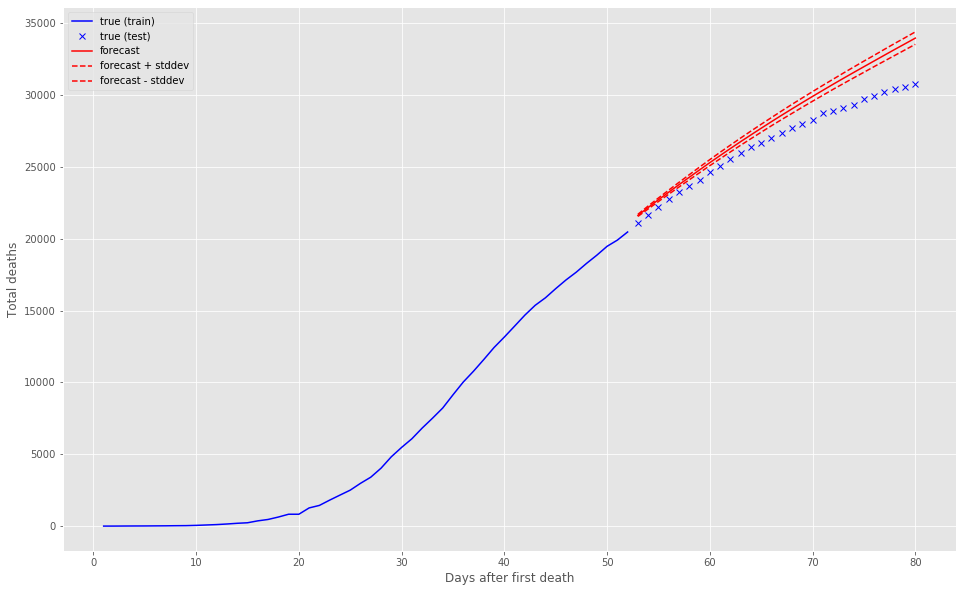

In [210]:
samples = fit3.extract(permuted=True)
y_hat_1 = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)
y_hat = np.zeros(T_t, dtype=int)
y_hat[0] = y_hat_1[0] + Italy[T_r]
for i in range(1,T_t):
    y_hat[i] = y_hat_1[i] + y_hat[i-1]
plt.plot(range(1,T_r), Italy[1:T_r], "b-")
plt.plot(range(T_r,T_r+T_t), Italy[T_r:T_r+T_t], "bx")
plt.plot(range(T_r,T_r+T_t), y_hat, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [211]:
corr, mae, rae, rmse, r2 = compute_error(Italy_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.996
MAE: 1414.07143
RMSE: 1645.21453
R2: 0.676


So our first real model performed moderately well. It has a much lower RMSE than the second base model but still only has an R2 of 0.676. The reason our forecasts are too high is because the testing set is after the point of inflection on the S-curve. So the model trains mostly on an increasing gradient. To counter this for the next model, we looked at how long after the first death in Italy did it take for the country to enter lockdown (e.g. government imposed social distancing). Italy locked down on the 9th of March which is 18 days after the first death

In [212]:
Ld_I = 18

In [213]:
model_2 = """
data {
    int<lower=1> T_t;
    int<lower=1> T_r;
    vector<lower=0>[T_r+T_t] y;
    int Ld;
}

parameters {
    real<lower=0> tau;
    real<lower=0,upper=2> beta;
    real<lower=0> sigma;
    real<lower=0> B;
    real<lower=0> C;
    vector<lower=0>[T_r] z;
}

model {
    beta ~ normal(0,1);
    tau ~ normal(0,1);
    sigma ~ normal(0,1);
    B ~ normal(0,1);
    C ~ normal(0,1);
    z[1] ~ normal(0,10);
    for(t in 2:(Ld+21)){
        z[t] ~ normal(beta*z[t-1],tau);
    }
    for(t in (Ld+22):T_r){
        z[t] ~ normal(C*z[t-1],tau);
    }
    y[1:T_r] ~ normal(B*z[1:T_r],sigma);
}

generated quantities {
    real y_hat[T_t];                         // vector to store predictions
    real z_hat[T_t];
    z_hat[1] = normal_rng(C*z[T_r],tau);
    for (t in 2:T_t){
        z_hat[t] = normal_rng(C*z_hat[t-1],tau);
    }
    for (t in 1:T_t) {
        y_hat[t] = normal_rng(B*z_hat[t],sigma);  // predictions
    }
}
"""

For this second model, we use Ld_I (days to lockdown after first death) to choose between two different distributions. It is similar to using a bernoulli variable to decide what distribution the latent states should have. However, the Ld_I is not modelled and is used as an indicator. The latent states are modelled against the input data for Italy using one set of parameters, but then 21 days after Ld_I is reached, the parameters are changed. These new parameters are then used to forecast z_hat and hence calculate y_hat. The parameters for y_hat are trained on both sets of variables for the latent state. We chose to switch parameters 21 days after lockdown, because the expected time to recovery for serious cases is at least 3 weeks. The second model has the following distributions:
$$z_t \sim Normal(z_t|\beta \cdot z_{t-1},\tau) \hspace{3cm} 0 < t < (Ld_I + 21)$$
$$z_t \sim Normal(z_t|C \cdot z_{t-1},\tau) \hspace{3cm} (Ld_I + 22) < t < TI_r$$
$$y_t \sim Normal(y_t|B \cdot z_t, \sigma) \hspace{7cm} $$

In [214]:
data4 = {'T_r': T_r, 'T_t': T_t, 'y': Italy_d, 'Ld':Ld_I}

In [215]:
%%time
sm4 = pystan.StanModel(model_code=model_2)
fit4 = sm4.sampling(data=data4, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ab909eee7c848b9a6c4e2ba3c3483eb NOW.


Inference for Stan model: anon_model_0ab909eee7c848b9a6c4e2ba3c3483eb.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau         8.75     0.2   0.57   7.69   8.37   8.71   9.12   9.95      8   1.21
beta        1.01  1.9e-3   0.03   0.95   0.99   1.01   1.03   1.07    240    1.0
sigma       0.78    0.14   0.38   0.16   0.54   0.74    1.0   1.63      8   1.28
B           8.38    0.27   0.57    7.3   8.08   8.39   8.66   9.85      4   1.56
C           0.96  1.7e-3   0.03    0.9   0.94   0.96   0.98   1.02    343   1.01
z[1]        0.14  4.0e-3   0.09   0.01   0.08   0.12   0.18   0.35    494   1.01
z[2]        0.14  4.1e-3   0.08   0.02   0.09   0.13   0.18   0.34    423   1.02
z[3]        0.15  5.7e-3   0.09   0.02   0.09   0.13   0.19   0.37    240   1.02
z[4]        0.48    0.01    0.1   0.28   0.43   0.48   0.54   0.71     54   1.04
z[5]

Text(0, 0.5, 'Total deaths')

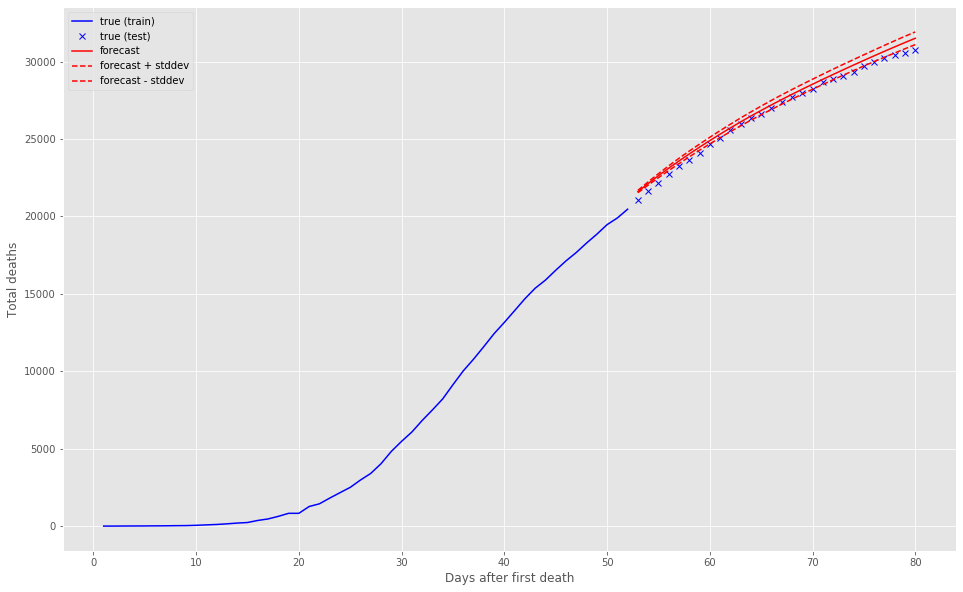

In [225]:
samples = fit4.extract(permuted=True)
y_hat_1 = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)
y_hat = np.zeros(T_t, dtype=int)
y_hat[0] = y_hat_1[0] + Italy[T_r]
for i in range(1,T_t):
    y_hat[i] = y_hat_1[i] + y_hat[i-1]
plt.plot(range(1,T_r), Italy[1:T_r], "b-")
plt.plot(range(T_r,T_r+T_t), Italy[T_r:T_r+T_t], "bx")
plt.plot(range(T_r,T_r+T_t), y_hat, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [217]:
corr, mae, rae, rmse, r2 = compute_error(Italy_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.999
MAE: 346.64286
RMSE: 382.58332
R2: 0.982


This model performs much better. It has taken the same basic structure as model 1 but now accounts for the slowed death rate once Italy entered lockdown. The forecasts only have an RMSE of 382.6 and an R2 of 0.982 compared with the actual results. For reference, the first base model had an RMSE of 390.4 and an R2 of 0.982, so this model is more accurate whilst also forecasting much further ahead.

Now we will try to include Spain in our model. Due to the fact that the data sets for Spain and Italy are different lengths (due to Italy's first death being before Spain's) we cannot forecast for both countries at the same time. Instead, we will use Spain to help model Italy. Firstly, we need Spain's time to lockdown. Spain locked down on the 14th of March which is 12 days after the first death

In [218]:
Ld_S = 12

In [219]:
model_3 = """
data {
    int<lower=1> TI_t;
    int<lower=1> TI_r;
    vector<lower=0>[TI_r+TI_t] y_I;
    int Ld_I;
    int<lower=1> TS_t;
    int<lower=1> TS_r;
    vector<lower=0>[TS_r+TS_t] y_S;
    int Ld_S;
}

parameters {
    cov_matrix[2] tau;
    matrix<lower=0,upper=2>[2,2] beta;
    real<lower=0> sigma;
    real<lower=0> rho;
    vector<lower=0>[2] B;
    vector<lower=0>[2] D;
    matrix<lower=0>[2,2] C;
    matrix<lower=0>[2,2] G;
    matrix<lower=0>[2,TI_r] z;
}

model {
    for(i in 1:2){
        B[i] ~ normal(0,1);
        D[i] ~ normal(0,1);
        for(j in 1:2){
            beta[i,j] ~ normal(0,1);
            tau[i,j] ~ normal(0,1);
            C[i,j] ~ normal(0,1);
            G[i,j] ~ normal(0,1);
        }
    }
    sigma ~ normal(0,1);
    rho ~ normal(0,1);
    z[:,1] ~ normal(0,10);
    for(t in 2:(Ld_S+21)){
        z[:,t] ~ multi_normal(beta*z[:,t-1],tau);
    }
    for(t in (Ld_S+22):(Ld_I+21)){
        z[:,t] ~ multi_normal(C*z[:,t-1],tau);
    }
    for(t in (Ld_I+22):TI_r){
        z[:,t] ~ multi_normal(G*z[:,t-1],tau);
    }
    y_I[1:TI_r] ~ normal(B'*z[:,1:TI_r],sigma);
    y_S[1:TI_r] ~ normal(D'*z[:,1:TI_r],rho);
}

generated quantities {
    real y_hat[TI_t];                         // vector to store predictions
    matrix[2,TI_t] z_hat;
    z_hat[:,1] = multi_normal_rng(G*z[:,TI_r],tau);
    for (t in 2:TI_t){
        z_hat[:,t] = multi_normal_rng(G*z_hat[:,t-1],tau);
    }
    for (t in 1:TI_t) {
        y_hat[t] = normal_rng(B'*z_hat[:,t],sigma);  // predictions
    }
}
"""

Model 3 is similar to the previous iteration of the model except now there are two latent states for each time. Hence, many parameters have been expanded from a scalar to two-by-two matrices. Tau is now a covariance matrix that we can use to see the correlations between the latent states. Also, we now change parameters twice; firstly, 21 days after the first of the two countries enters lockdown (this happens to be Spain), and secondly when the other country enters lockdown. Hence, the following distributions are used:
$$z_t \sim Normal(z_t|\beta \cdot z_{t-1},\tau) \hspace{3cm} 0 < t < (Ld_S + 21)$$
$$z_t \sim Normal(z_t|C \cdot z_{t-1},\tau) \hspace{3cm} (Ld_S + 22) < t < (Ld_I + 21)$$
$$z_t \sim Normal(z_t|G\cdot z_{t-1},\tau) \hspace{3cm} (Ld_I + 22) < t < TI_r$$
$$y_t \sim Normal(y_t|B \cdot z_t, \sigma) \hspace{7cm} $$

In [258]:
TI_r = len(Italy_train)
TI_t = len(Italy_test)
TS_r = len(Spain_train)
TS_t = len(Spain_test)
data5 = {'TI_r': TI_r, 'TI_t': TI_t, 'y_I': Italy_d,'TS_r': TS_r, 'TS_t': TS_t, 'y_S': Spain_d, 'Ld_I':Ld_I, 'Ld_S':Ld_S}

In [221]:
%%time
sm5 = pystan.StanModel(model_code=model_3)
fit5 = sm5.sampling(data=data5, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit5)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c61043b02c79512d43c2a8a77a5380b5 NOW.


Inference for Stan model: anon_model_c61043b02c79512d43c2a8a77a5380b5.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
tau[1,1]     10.59    0.43   0.85   8.66   10.05  10.65   11.2  11.99      4   1.51
tau[2,1]     -0.36    0.06   0.41  -1.13   -0.65  -0.35  -0.07   0.42     41   1.15
tau[1,2]     -0.36    0.06   0.41  -1.13   -0.65  -0.35  -0.07   0.42     41   1.15
tau[2,2]      9.78    0.43   0.79   8.51    9.16   9.68  10.33  11.46      3   1.59
beta[1,1]      0.7    0.15   0.21   0.24    0.62    0.8   0.84   0.89      2    4.1
beta[2,1]     0.42    0.04   0.07   0.24    0.38   0.43   0.47   0.54      4   1.51
beta[1,2]     0.37    0.04   0.08   0.22    0.31   0.36   0.43   0.54      5   1.38
beta[2,2]     0.46    0.14   0.21   0.22    0.32   0.38   0.63   0.87      2   3.77
sigma         1.42    0.53    0.9   0.35    0.69   1.14   

Text(0, 0.5, 'Total deaths')

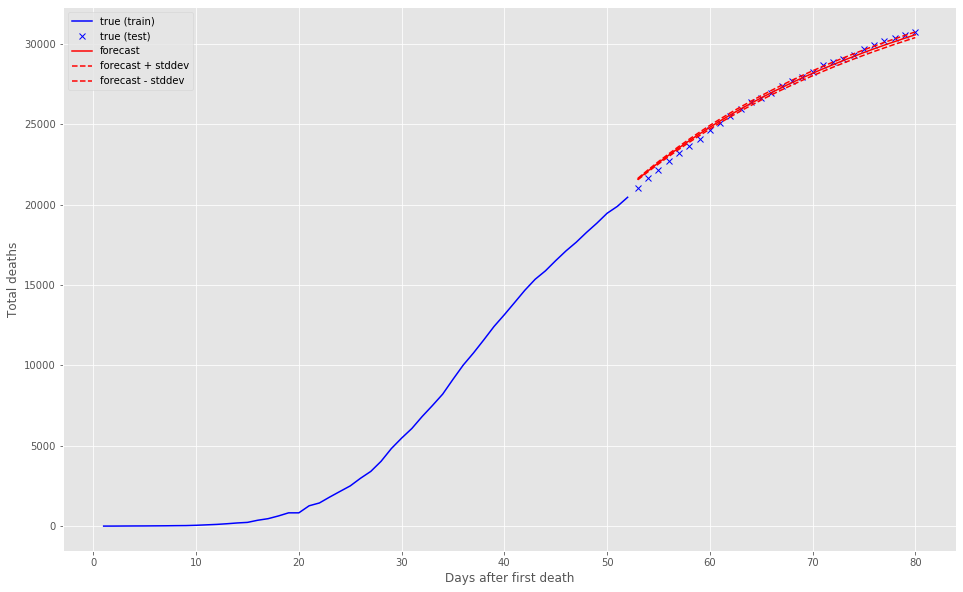

In [226]:
samples = fit5.extract(permuted=True)
y_hat_1 = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)
y_hat = np.zeros(T_t, dtype=int)
y_hat[0] = y_hat_1[0] + Italy[T_r]
for i in range(1,T_t):
    y_hat[i] = y_hat_1[i] + y_hat[i-1]
plt.plot(range(1,T_r), Italy[1:T_r], "b-")
plt.plot(range(T_r,T_r+T_t), Italy[T_r:T_r+T_t], "bx")
plt.plot(range(T_r,T_r+T_t), y_hat, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [223]:
corr, mae, rae, rmse, r2 = compute_error(Italy_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 1.000
MAE: 191.35714
RMSE: 238.29768
R2: 0.993


This model performs very well with an RMSE of 238.3 and an R2 of 0.993.

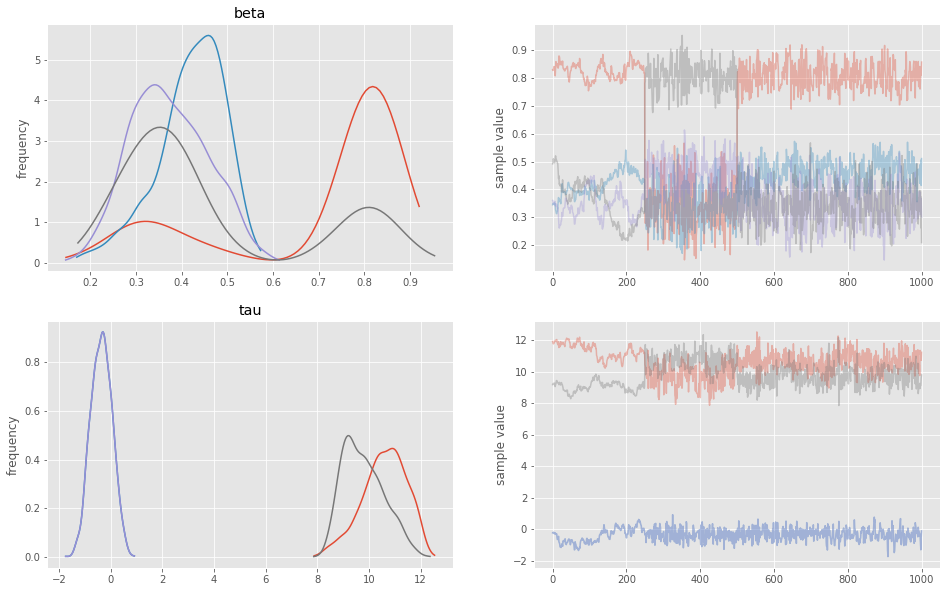

In [290]:
fit5.plot(["beta","tau"])
plt.show()

Text(0, 0.5, 'Total deaths')

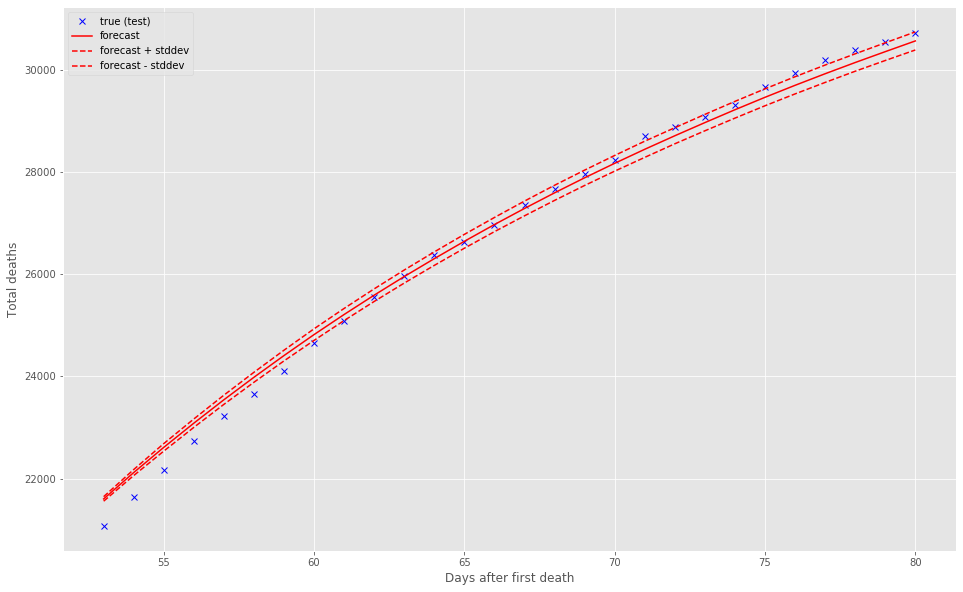

In [227]:
plt.plot(range(T_r,T_r+T_t), Italy[T_r:T_r+T_t], "bx")
plt.plot(range(T_r,T_r+T_t), y_hat, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat - y_std, "r--")
plt.legend(["true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

Text(0, 0.5, 'Daily deaths')

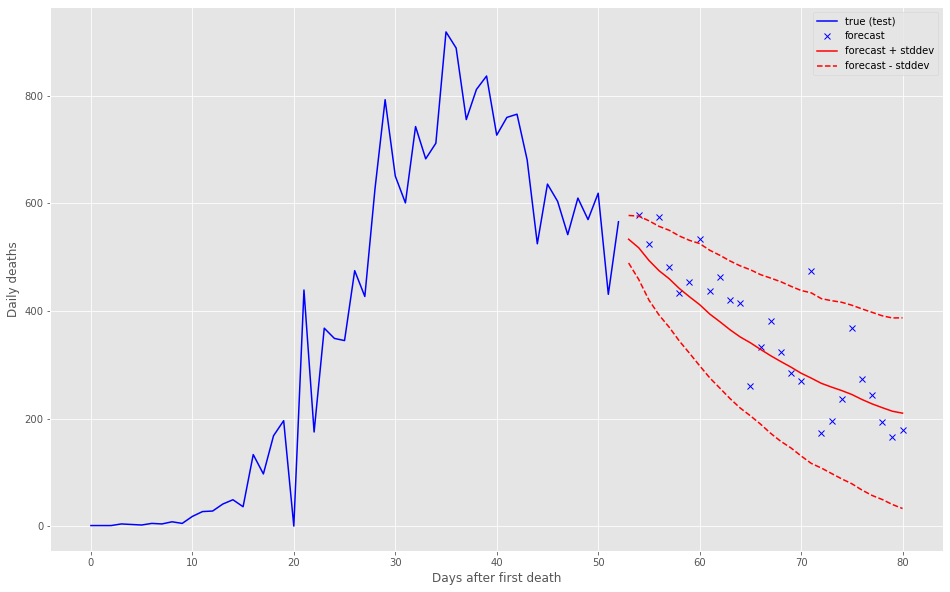

In [228]:
plt.plot(range(TI_r),Italy_d[0:TI_r], "b-")
plt.plot(range(TI_r+1,TI_r+TI_t),Italy_d[TI_r+1:TI_r+TI_t],"bx")
plt.plot(range(T_r,T_r+T_t), y_hat_1, "r-")
plt.plot(range(T_r,T_r+T_t), y_hat_1 + y_std, "r--")
plt.plot(range(T_r,T_r+T_t), y_hat_1 - y_std, "r--")
plt.legend(["true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Daily deaths")

This is the plot of the forecast for daily deaths. It shows that only 3 of the 27 real data points fall outside the standard deviation bounds.

The next model uses the same principles but is variable. You can choose any two countries from below and use one to help train the other as we did with Spain and Italy before.

                1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Italy                 0        0        0        0        0        0        0   
Spain                 0        0        0        0        0        0        0   
China                17       18       26       42       56       82      131   
US                    0        0        0        0        0        0        0   
United Kingdom        0        0        0        0        0        0        0   
Iran                  0        0        0        0        0        0        0   
Brazil                0        0        0        0        0        0        0   
France                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  ...  5/2/20  5/3/20  5/4/20  \
Country/Region                             ...                           
Italy                 0        0        0

Text(0, 0.5, 'Total deaths')

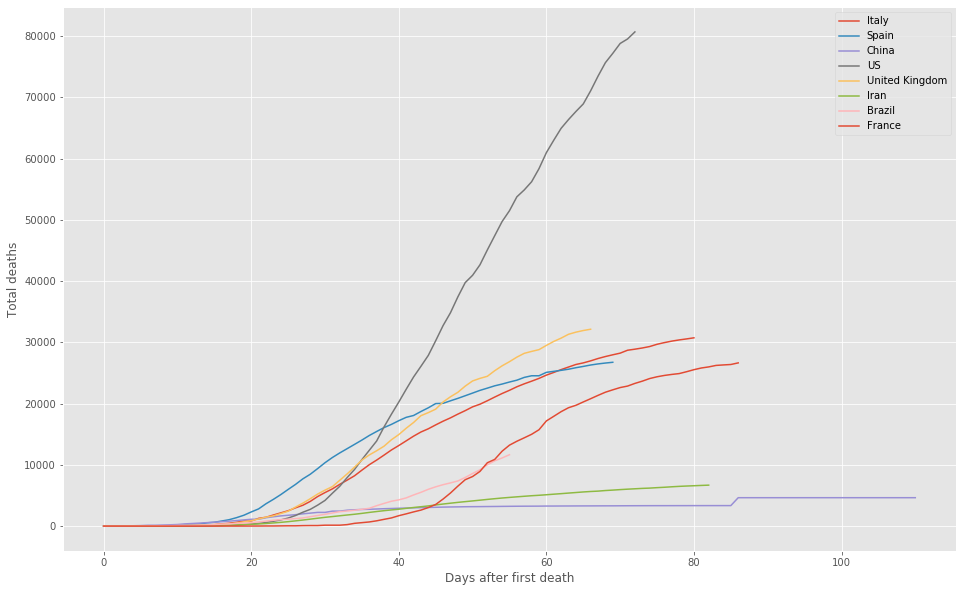

In [229]:
df7 = df2.iloc[0:265,1:112][0:265].astype(int)
df8 = pd.merge(df2.loc[:,'Country/Region'][0:265],df7,left_index=True,right_index=True)
df9 = df8.groupby(['Country/Region']).sum()
df10 = df9.loc[['Italy','Spain','China','US','United Kingdom','Iran','Brazil','France']]
print(df10)
y = df10.values
Italy = y[0,:][np.nonzero(y[0,:])]
Spain = y[1,:][np.nonzero(y[1,:])]
China = y[2,:][np.nonzero(y[2,:])]
USA = y[3,:][np.nonzero(y[3,:])]
UK = y[4,:][np.nonzero(y[4,:])]
Iran = y[5,:][np.nonzero(y[5,:])]
Brazil = y[6,:][np.nonzero(y[6,:])]
France = y[7,:][np.nonzero(y[7,:])]
plt.plot(range(81),Italy,range(70),Spain,range(111),China,range(73),USA,range(67),UK,range(83),Iran,range(56),Brazil,range(87),France)
plt.legend(df10.index.values)
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [230]:
print("num train Spain: %d" % len(Spain_train))
print("num test Spain: %d" % len(Spain_test))
print("num train Italy: %d" % len(Italy_train))
print("num test Italy: %d" % len(Italy_test))
split_point_C = int(train_perc*len(China))
China_train = China[:split_point_C]
China_test = China[split_point_C:]
split_point_US = int(train_perc*len(USA))
USA_train = USA[:split_point_US]
USA_test = USA[split_point_US:]
print("num train China: %d" % len(China_train))
print("num test China: %d" % len(China_test))
print("num train USA: %d" % len(USA_train))
print("num test USA: %d" % len(USA_test))
split_point_UK = int(train_perc*len(UK))
UK_train = UK[:split_point_UK]
UK_test = UK[split_point_UK:]
split_point_IR = int(train_perc*len(Iran))
Iran_train = Iran[:split_point_IR]
Iran_test = Iran[split_point_IR:]
print("num train UK: %d" % len(UK_train))
print("num test UK: %d" % len(UK_test))
print("num train Iran: %d" % len(Iran_train))
print("num test Iran: %d" % len(Iran_test))
split_point_B = int(train_perc*len(Brazil))
Brazil_train = Brazil[:split_point_B]
Brazil_test = Brazil[split_point_B:]
split_point_F = int(train_perc*len(France))
France_train = France[:split_point_F]
France_test = France[split_point_F:]
print("num train Brazil: %d" % len(Brazil_train))
print("num test Brazil: %d" % len(Brazil_test))
print("num train France: %d" % len(France_train))
print("num test France: %d" % len(France_test))

num train Spain: 46
num test Spain: 24
num train Italy: 53
num test Italy: 28
num train China: 73
num test China: 38
num train USA: 48
num test USA: 25
num train UK: 44
num test UK: 23
num train Iran: 54
num test Iran: 29
num train Brazil: 36
num test Brazil: 20
num train France: 57
num test France: 30


In [231]:
China_d = np.zeros(len(China),dtype=int)
USA_d = np.zeros(len(USA),dtype=int)
UK_d = np.zeros(len(UK),dtype=int)
Iran_d = np.zeros(len(Iran),dtype=int)
Brazil_d = np.zeros(len(Brazil),dtype=int)
France_d = np.zeros(len(France),dtype=int)
China_d[0] = China[0]
USA_d[0] = USA[0]
UK_d[0] = UK[0]
Iran_d[0] = Iran[0]
Brazil_d[0] = Brazil[0]
France_d[0] = France[0]
for i in range(1,len(China)):
    China_d[i] = China[i] - China[i-1]
for i in range(1,len(USA)):
    USA_d[i] = USA[i] - USA[i-1]
for i in range(1,len(UK)):
    UK_d[i] = UK[i] - UK[i-1]
for i in range(1,len(Iran)):
    Iran_d[i] = Iran[i] - Iran[i-1]
for i in range(1,len(Brazil)):
    Brazil_d[i] = Brazil[i] - Brazil[i-1]
for i in range(1,len(France)):
    France_d[i] = France[i] - France[i-1]

For many of these countries, they locked down different parts of the country on different dates. We will be taking the first lockdown date for a country. Some things to note are that Brazil began lockdown on the same day it had it's first death. France's first death was actually 12 days before it's second, which is anomalous, and so we have decided to measure France's time to lockdown from it's second death instead. China began lockdown on the 23rd of January and our data has only been recorded starting on the 22nd of January; hence China's time to lockdown is 2 even though it's first death actually was recorded on January 11th.

In [232]:
Ld_C = 2
Ld_US = 20
Ld_UK = 18
Ld_IR = 25
Ld_B = 1
Ld_F = 21

In [233]:
model_4 = """
data {
    int<lower=1> T_t;
    int<lower=1> T_r;
    vector<lower=0>[T_r+T_t] y;
    int Ld_h;
    int<lower=1> Tx_t;
    int<lower=1> Tx_r;
    vector<lower=0>[Tx_r+Tx_t] x;
    int Ld_l;
}

parameters {
    cov_matrix[2] tau;
    matrix<lower=0,upper=2>[2,2] beta;
    real<lower=0> sigma1;
    real<lower=0> sigma2;
    vector<lower=0>[2] B1;
    vector<lower=0>[2] B2;
    matrix<lower=0>[2,2] C1;
    matrix<lower=0>[2,2] C2;
    matrix<lower=0>[2,T_r] z;
}

model {
    for(i in 1:2){
        B1[i] ~ normal(0,1);
        B2[i] ~ normal(0,1);
        for(j in 1:2){
            beta[i,j] ~ normal(0,1);
            tau[i,j] ~ normal(0,1);
            C1[i,j] ~ normal(0,1);
            C2[i,j] ~ normal(0,1);
        }
    }
    sigma1 ~ normal(0,1);
    sigma2 ~ normal(0,1);
    z[:,1] ~ normal(0,10);
    for(t in 2:(Ld_l+21)){
        z[:,t] ~ multi_normal(beta*z[:,t-1],tau);
    }
    for(t in (Ld_l+22):(Ld_h+21)){
        z[:,t] ~ multi_normal(C1*z[:,t-1],tau);
    }
    for(t in (Ld_h+22):T_r){
        z[:,t] ~ multi_normal(C2*z[:,t-1],tau);
    }
    y[1:T_r] ~ normal(B1'*z[:,1:T_r],sigma1);
    x[1:T_r] ~ normal(B2'*z[:,1:T_r],sigma2);
}

generated quantities {
    real y_hat[T_t];                         // vector to store predictions
    matrix[2,T_t] z_hat;
    z_hat[:,1] = multi_normal_rng(C2*z[:,T_r],tau);
    for (t in 2:T_t){
        z_hat[:,t] = multi_normal_rng(C2*z_hat[:,t-1],tau);
    }
    for (t in 1:T_t) {
        y_hat[t] = normal_rng(B1'*z_hat[:,t],sigma1);  // predictions
    }
}
"""

This is the same model as before except you can now pick any of the two countries. Choose the first three data to be from the country you wish to test and the second three data to be from the country you wish to train with. Pick Ld_h to be the larger of the two times to lockdown and Ld_l the smaller. For this example, we will use the UK to help forecast the USA.

In [241]:
TI_r = len(Italy_train)
TI_t = len(Italy_test)
TS_r = len(Spain_train)
TS_t = len(Spain_test)
TC_r = len(China_train)
TC_t = len(China_test)
TUS_r = len(USA_train)
TUS_t = len(USA_test)
TUK_r = len(UK_train)
TUK_t = len(UK_test)
TIR_r = len(Iran_train)
TIR_t = len(Iran_test)
TB_r = len(Brazil_train)
TB_t = len(Brazil_test)
TF_r = len(France_train)
TF_t = len(France_test)
data6 = {'T_r': TUK_r, 'T_t': TUK_t, 'y': UK_d,'Tx_r': TI_r, 'Tx_t': TI_t, 'x': Italy_d, 'Ld_h':Ld_I, 'Ld_l':Ld_UK}

In [242]:
%%time
sm6 = pystan.StanModel(model_code=model_4)
fit6 = sm6.sampling(data=data6, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit6)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de21c73842f8f0cf040937984eb9744e NOW.


Inference for Stan model: anon_model_de21c73842f8f0cf040937984eb9744e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau[1,1]      9.94    0.07   0.66    8.7   9.47   9.91  10.35  11.24     86   1.04
tau[2,1]      1.42    0.04   0.44   0.62   1.12    1.4   1.71    2.3    151    1.0
tau[1,2]      1.42    0.04   0.44   0.62   1.12    1.4   1.71    2.3    151    1.0
tau[2,2]      9.74    0.08   0.66   8.54   9.28    9.7  10.18  11.13     66   1.07
beta[1,1]     0.73     0.1   0.15    0.4   0.65   0.78   0.83   0.91      2   2.49
beta[2,1]     0.46    0.12   0.18   0.09   0.37   0.53   0.59   0.69      2   2.69
beta[1,2]     0.28    0.12   0.18   0.08   0.16   0.21   0.36   0.66      2   2.97
beta[2,2]     0.58     0.1   0.15   0.38   0.47   0.53   0.66   0.91      2   2.33
sigma1        1.05    0.07   0.48   0.44    0.7   0.94   1.29   2.3

Text(0, 0.5, 'Total deaths')

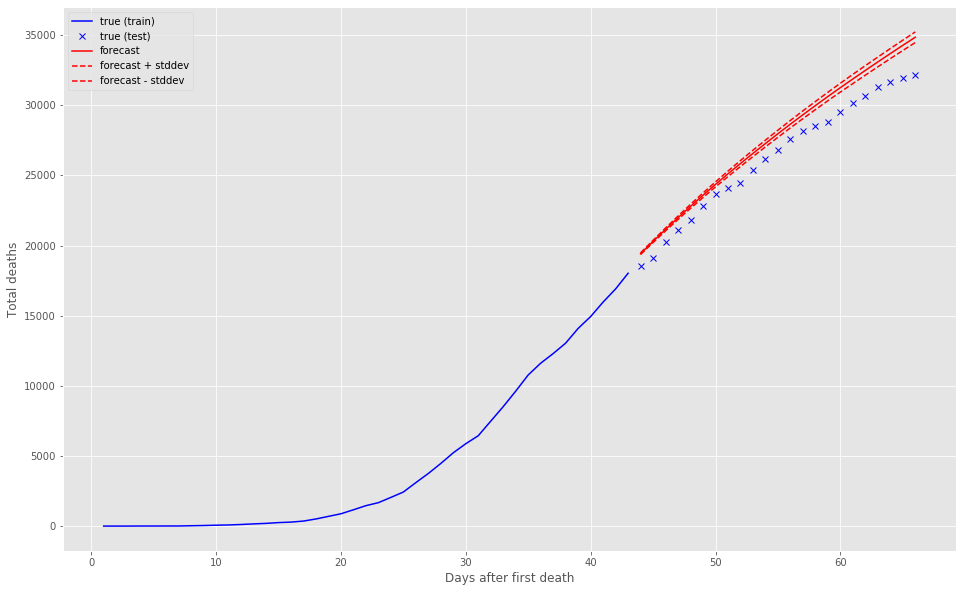

In [244]:
samples = fit6.extract(permuted=True)
y_hat_1 = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)
y_hat = np.zeros(TUK_t, dtype=int)
y_hat[0] = y_hat_1[0] + UK[TUK_r]
for i in range(1,TUK_t):
    y_hat[i] = y_hat_1[i] + y_hat[i-1]
plt.plot(range(1,TUK_r), UK[1:TUK_r], "b-")
plt.plot(range(TUK_r,TUK_r+TUK_t), UK[TUK_r:TUK_r+TUK_t], "bx")
plt.plot(range(TUK_r,TUK_r+TUK_t), y_hat, "r-")
plt.plot(range(TUK_r,TUK_r+TUK_t), y_hat + y_std, "r--")
plt.plot(range(TUK_r,TUK_r+TUK_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Total deaths")

In [246]:
corr, mae, rae, rmse, r2 = compute_error(UK_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.998
MAE: 1378.73913
RMSE: 1474.21294
R2: 0.876


Text(0, 0.5, 'Daily deaths')

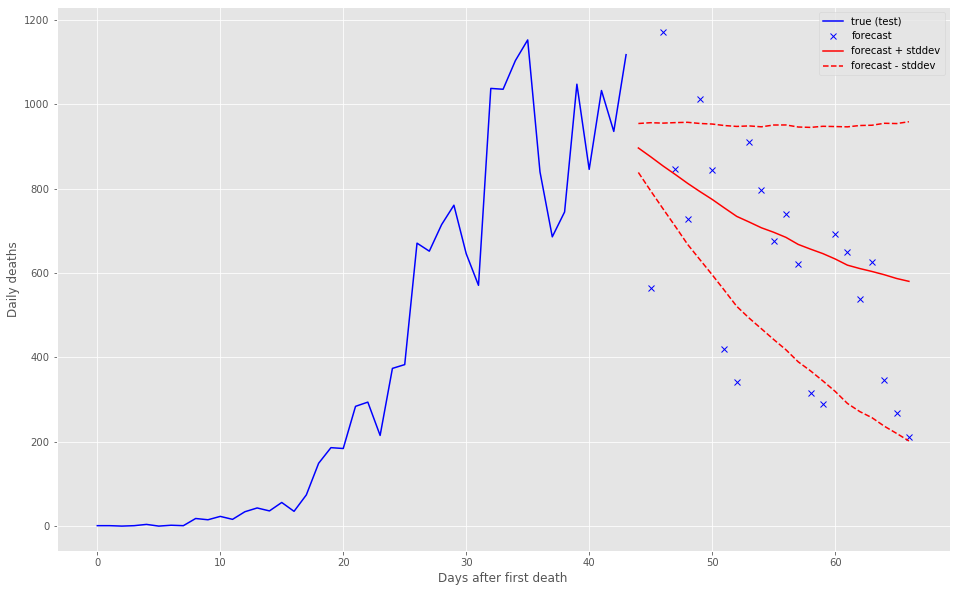

In [248]:
plt.plot(range(TUK_r),UK_d[0:TUK_r], "b-")
plt.plot(range(TUK_r+1,TUK_r+TUK_t),UK_d[TUK_r+1:TUK_r+TUK_t],"bx")
plt.plot(range(TUK_r,TUK_r+TUK_t), y_hat_1, "r-")
plt.plot(range(TUK_r,TUK_r+TUK_t), y_hat_1 + y_std, "r--")
plt.plot(range(TUK_r,TUK_r+TUK_t), y_hat_1 - y_std, "r--")
plt.legend(["true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.xlabel("Days after first death")
plt.ylabel("Daily deaths")

Now we will try to improve the previous model looking at Italy and Spain by adding some external data, specifically, the number of cases in each of those countries.

In [266]:
cf1 = pd.read_csv("time_series_covid19_confirmed_global.csv.txt")
cf2 = cf1.drop(cf1.columns[[0,2,3]], axis=1)
cf3 = cf2.iloc[0:265,30:112][0:265].astype(int)
cf4 = pd.merge(cf2.loc[:,'Country/Region'][0:265],cf3,left_index=True,right_index=True)
cf5 = cf4.groupby(['Country/Region']).sum()
cf6 = cf5.loc[['Italy','Spain']]
yc = cf6.values
Italy_c = yc[0,0:81][np.nonzero(yc[0,0:81])]
Spain_c = yc[1,1:82][np.nonzero(yc[1,1:82])]
Spain_c = np.sort(Spain_c)
print(Italy_c)
print(Spain_c)

[     3     20     62    155    229    322    453    655    888   1128
   1694   2036   2502   3089   3858   4636   5883   7375   9172  10149
  12462  15113  17660  21157  24747  27980  31506  35713  41035  47021
  53578  59138  63927  69176  74386  80589  86498  92472  97689 101739
 105792 110574 115242 119827 124632 128948 132547 135586 139422 143626
 147577 152271 156363 159516 162488 165155 168941 172434 175925 178972
 181228 183957 187327 189973 192994 195351 197675 199414 201505 203591
 205463 207428 209328 210717 211938 213013 214457 215858 217185 218268
 219070]
[     2      2      2      2      6     13     15     32     45     84
    120    165    222    259    400    500    673   1073   1695   2277
   2277   5232   6391   7798   9942  11748  13910  17963  20410  25374
  28768  35136  39885  49515  57786  65719  73235  80110  87956  95923
 104118 112065 119199 126168 131646 136675 141942 148220 153222 158273
 163027 166831 170099 172541 177644 184948 190839 191726 198674 2002

Text(0, 0.5, 'Total cases')

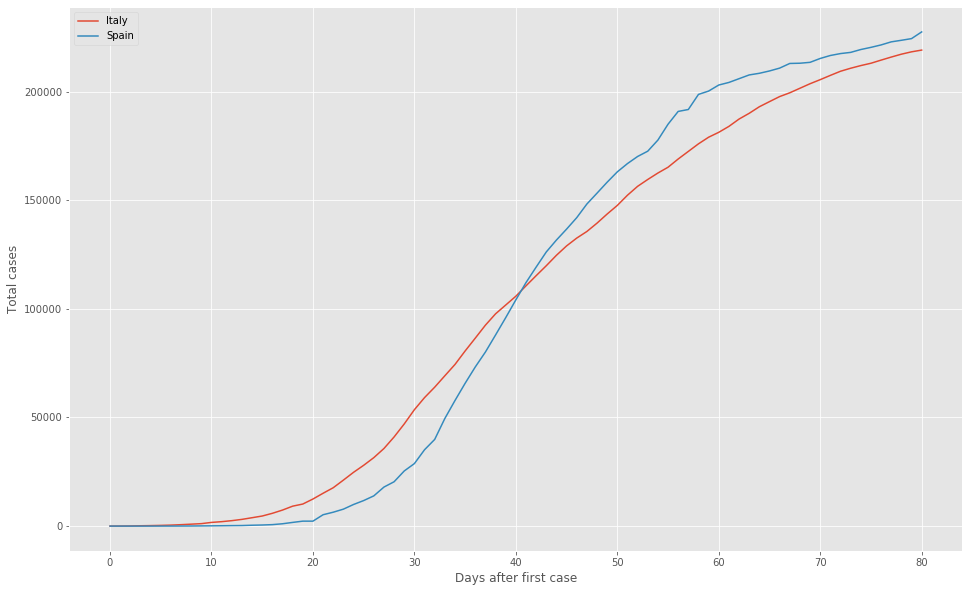

In [267]:
plt.plot(range(81),Italy_c,range(81),Spain_c)
plt.legend(cf6.index.values)
plt.xlabel("Days after first case")
plt.ylabel("Total cases")

In [268]:
Italy_cd = np.zeros(len(Italy_c),dtype=int)
Spain_cd = np.zeros(len(Spain_c),dtype=int)
Italy_cd[0] = Italy_c[0]
Spain_cd[0] = Spain_c[0]
for i in range(1,len(Italy_c)):
    Italy_cd[i] = Italy_c[i] - Italy_c[i-1]
for i in range(1,len(Spain_c)):
    Spain_cd[i] = Spain_c[i] - Spain_c[i-1]
print(Italy_cd)
print(Spain_cd)

[   3   17   42   93   74   93  131  202  233  240  566  342  466  587
  769  778 1247 1492 1797  977 2313 2651 2547 3497 3590 3233 3526 4207
 5322 5986 6557 5560 4789 5249 5210 6203 5909 5974 5217 4050 4053 4782
 4668 4585 4805 4316 3599 3039 3836 4204 3951 4694 4092 3153 2972 2667
 3786 3493 3491 3047 2256 2729 3370 2646 3021 2357 2324 1739 2091 2086
 1872 1965 1900 1389 1221 1075 1444 1401 1327 1083  802]
[   2    0    0    0    4    7    2   17   13   39   36   45   57   37
  141  100  173  400  622  582    0 2955 1159 1407 2144 1806 2162 4053
 2447 4964 3394 6368 4749 9630 8271 7933 7516 6875 7846 7967 8195 7947
 7134 6969 5478 5029 5267 6278 5002 5051 4754 3804 3268 2442 5103 7304
 5891  887 6948 1536 2780 1188 1727 1729  755 1076 1308 2144  107  411
 1781 1366  884  545 1318  996 1122 1410  721  772 3086]


In [320]:
model_5 = """
data {
    int<lower=1> TI_t;
    int<lower=1> TI_r;
    vector<lower=0>[TI_r+TI_t] y_I;
    int Ld_I;
    int<lower=1> TS_t;
    int<lower=1> TS_r;
    vector<lower=0>[TS_r+TS_t] y_S;
    int Ld_S;
    matrix[2,TI_r+TI_t] yc;
    real pd_I;
    real urb_I;
    
}

parameters {
    cov_matrix[2] tau;
    matrix<lower=0,upper=2>[2,2] beta;
    real<lower=0> sigma;
    real<lower=0> rho;
    vector<lower=0>[2] B;
    vector<lower=0>[2] D;
    matrix<lower=0>[2,2] C;
    matrix<lower=0>[2,2] G;
    matrix<lower=0>[2,TI_r] z;
    matrix<lower=0>[2,2] W;
    
}

model {
    for(i in 1:2){
        B[i] ~ normal(0,1);
        D[i] ~ normal(0,1);
        for(j in 1:2){
            beta[i,j] ~ normal(0,1);
            tau[i,j] ~ normal(0,1);
            C[i,j] ~ normal(0,1);
            G[i,j] ~ normal(0,1);
            W[i,j] ~ normal(0,0.1);
        }
    }
    sigma ~ normal(0,1);
    rho ~ normal(0,1);
    z[:,1] ~ normal(W*yc[:,1],10);
    for(t in 2:(Ld_S+10)){
        z[:,t] ~ multi_normal(beta*z[:,t-1] + W*yc[:,t],tau);
    }
    for(t in (Ld_S+11):(Ld_I+10)){
        z[:,t] ~ multi_normal(C*z[:,t-1] + W*yc[:,t],tau);
    }
    for(t in (Ld_I+11):TI_r){
        z[:,t] ~ multi_normal(G*z[:,t-1] + W*yc[:,t],tau);
    }
    y_I[1:TI_r] ~ normal(B'*z[:,1:TI_r],sigma);
    y_S[1:TI_r] ~ normal(D'*z[:,1:TI_r],rho);
}

generated quantities {
    real y_hat[TI_t];                         // vector to store predictions
    matrix[2,TI_t] z_hat;
    z_hat[:,1] = multi_normal_rng(G*z[:,TI_r] + W*yc[:,TI_r+1],tau);
    for (t in 2:TI_t){
        z_hat[:,t] = multi_normal_rng(G*z_hat[:,t-1] + W*yc[:,TI_r+t],tau);
    }
    for (t in 1:TI_t) {
        y_hat[t] = normal_rng((B'*z_hat[:,t]),sigma) - (pd_I/urb_I)*t*2 ;  // predictions
    }
}
"""

In [321]:
yc_I = Italy_cd
yc_S = Spain_cd
ycc = np.zeros([2,len(Italy_cd)],dtype=int)
ycc[0,:] = yc_I
ycc[1,:] = yc_S
ycc = np.log(ycc)
ycc[1,(1,2,3,20)] = 0
print(ycc)
data7 = {'TI_r': TI_r, 'TI_t': TI_t, 'y_I': Italy_d,'TS_r': TS_r, 'TS_t': TS_t, 'y_S': Spain_d, 'Ld_I':Ld_I, 'Ld_S':Ld_S,\
        'yc':ycc, 'pd_I':pd_I, 'urb_I':urb_I}

[[1.09861229 2.83321334 3.73766962 4.53259949 4.30406509 4.53259949
  4.87519732 5.3082677  5.45103845 5.48063892 6.33859408 5.83481074
  6.14418563 6.37502482 6.64509097 6.65672652 7.12849595 7.30787278
  7.49387389 6.88448665 7.74630066 7.88269221 7.84267147 8.15966074
  8.18590748 8.08116578 8.16791936 8.34450508 8.57960445 8.69717869
  8.78828846 8.62335339 8.4740769  8.56579286 8.55833513 8.73278832
  8.68423189 8.695172   8.5596778  8.30647216 8.30721263 8.47261415
  8.44848599 8.43054538 8.47741232 8.37008433 8.18841131 8.01928379
  8.25218544 8.34379173 8.28172399 8.45404038 8.31678913 8.05610966
  7.99699041 7.88870952 8.23906533 8.15851624 8.15794351 8.02191278
  7.72134861 7.91169052 8.12266802 7.88080434 8.01334318 7.7651449
  7.75104512 7.46106551 7.6453977  7.64300364 7.53476266 7.58324752
  7.54960917 7.23633934 7.10742547 6.98007594 7.27517232 7.24494155
  7.19067603 6.98749025 6.68710861]
 [0.69314718 0.         0.         0.         1.38629436 1.94591015
  0.69314718 

C:\Users\jorda\Anaconda3\envs\mbml\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [322]:
%%time
sm7 = pystan.StanModel(model_code=model_5)
fit7 = sm7.sampling(data=data7, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit7)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a791a9c2e52fbba164e89f5895016e10 NOW.


Inference for Stan model: anon_model_a791a9c2e52fbba164e89f5895016e10.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau[1,1]     10.24    0.45   0.87   8.46   9.69  10.35  10.88  11.86      4   1.55
tau[2,1]      0.34    0.02   0.36  -0.38   0.12   0.42   0.53   1.01    262   1.02
tau[1,2]      0.34    0.02   0.36  -0.38   0.12   0.42   0.53   1.01    262   1.02
tau[2,2]      9.52    0.54   0.94   7.98   8.92   9.22   10.1  11.59      3   1.85
beta[1,1]      0.6    0.23   0.33 4.0e-3   0.33   0.72   0.82   0.96      2   4.68
beta[2,1]     0.59    0.02   0.14   0.35   0.53   0.58   0.63   0.95     40   1.12
beta[1,2]     0.69    0.05   0.18   0.36   0.55   0.66   0.84   1.06     12   1.14
beta[2,2]     0.23    0.24   0.34 1.4e-3   0.02   0.04   0.42   0.95      2   6.56
sigma         0.92    0.24   0.62   0.13   0.41   0.81   1.28   2.4

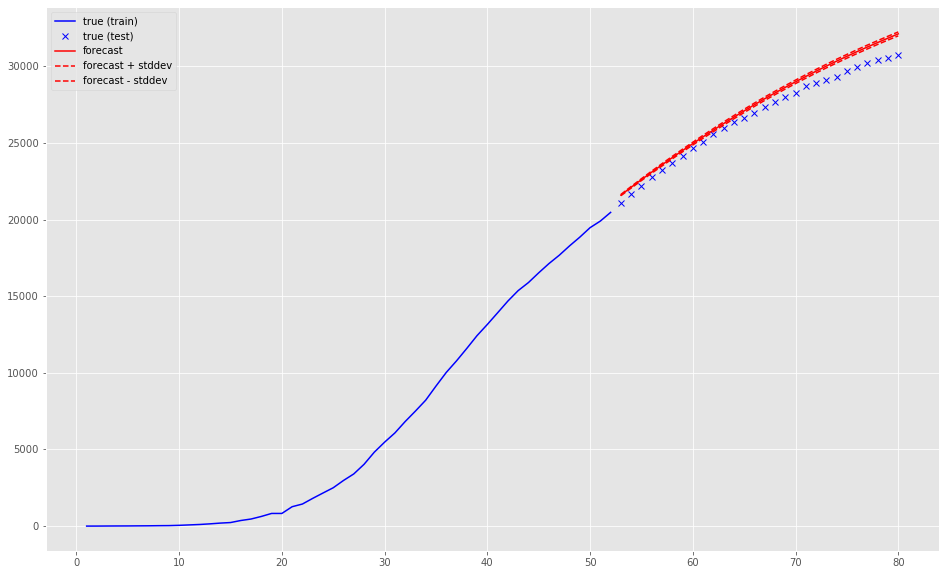

In [323]:
samples = fit7.extract(permuted=True)
y_hat_1 = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)
y_hat = np.zeros(TI_t, dtype=int)
y_hat[0] = y_hat_1[0] + Italy[TI_r]
for i in range(1,TI_t):
    y_hat[i] = y_hat_1[i] + y_hat[i-1]
plt.plot(range(1,TI_r), Italy[1:TI_r], "b-")
plt.plot(range(TI_r,TI_r+TI_t), Italy[TI_r:TI_r+TI_t], "bx")
plt.plot(range(TI_r,TI_r+TI_t), y_hat, "r-")
plt.plot(range(TI_r,TI_r+TI_t), y_hat + y_std, "r--")
plt.plot(range(TI_r,TI_r+TI_t), y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

In [327]:
corr, mae, rae, rmse, r2 = compute_error(Italy_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.998
MAE: 641.67857
RMSE: 718.49896
R2: 0.938


This final model uses external parameters for population density and percent of population living in urban areas. It performs very well as a higher population density brings a faster increase in death rate. So after lockdown measures have been taken, during the forecasting, the death rate decreases faster.